# Reconstruction of DOSY NMR signals - Part I

Anne GAGNEUX, Clémence GRISLAIN

## Generation of synthetic data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

In [ ]:
# Download data
data = []
with open("x.txt", mode = 'r') as signal : 
    for line in signal:
        data.append(float(line))

N = len(data)

In [ ]:
# Create T
Tmin = 1.
Tmax= 1000.
T = [Tmin*np.exp(-(n-1)  *np.log(Tmin/Tmax) / (N-1)) for n in range(1,N+1) ]

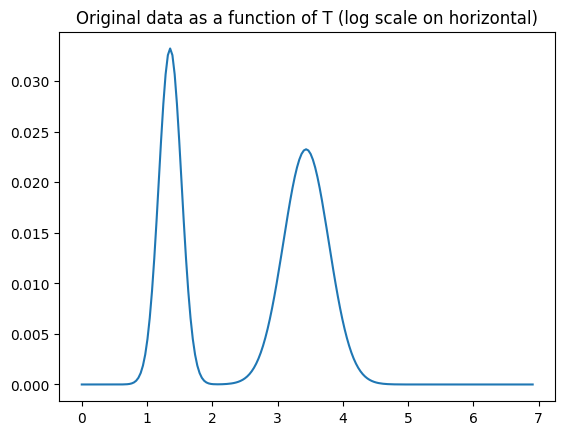

In [ ]:
plt.plot(np.log(T),data)
plt.title("Original data as a function of T (log scale on horizontal)")
plt.show()

In [ ]:
# Construct matrix K
M = 50
tmin = 0 
tmax= 1.5

t = [tmin + (m-1)/(M-1)* (tmax-tmin) for m in range(1,M+1)]

K = np.zeros((M,N))
for n in range(N):
    for m in range(M):
        K[m,n]=np.exp(-T[n]*t[m])

In [ ]:
# Simulation of the noisy data 
np.random.seed(1)
z = K @ data
sigma = 0.01 * z[0]
w = np.random.normal(0,sigma,size = M)
y = z + w

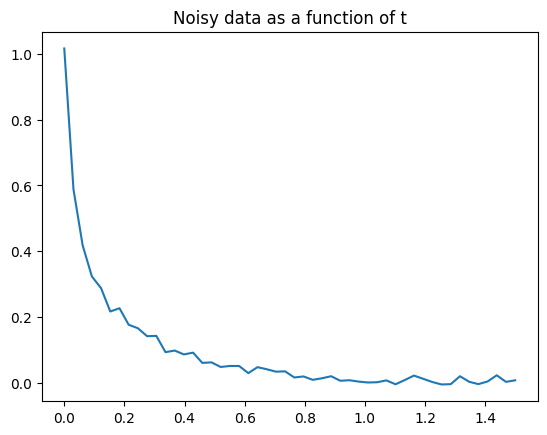

In [ ]:
plt.plot(t,y)
plt.title("Noisy data as a function of t")
plt.show()

## Comparison of regularization strategies

### Cas 1 : smoothness prior

$$\hat{x} = \underset{x \in \mathbb{R}^N}{\text{argmin }} \frac{1}{2}||Kx - y ||^2 + \frac{\beta}{2} ||Dx||^2 $$ 

In [ ]:
D = np.zeros((N,N))
for i in range(1,N):
    D[i,i] = 1
    D[i,i-1] = -1
    
D[0,0] = 1
D[0,-1] = -1

1) The function $F: x \longrightarrow \frac{1}{2}||Kx - y ||^2 + \frac{\beta}{2} ||Dx||^2 $ is differentiable and we have:

$$\nabla F(x) = K^T(Kx - y) + \beta\times D^TDx$$
$$\nabla^2 F = K^TK + \beta\times D^TD$$

- $F$ is twice differentiable on $\mathbb{R}^N$.
- $F$ is convex as its hessian is positive semi-definite 

so its critical points are local minima of F.
Thus there exist solutions to the problem. 

If we have a strong convexity $\equiv$ $\nabla ^2 > 0$,then we have the uniqueness of the solution.

Let's check numerically if $\nabla^2 F = K^TK + \beta\times D^TD$ is invertible

As $K^T K x \geq 0 \forall x$ and $D^T K x \geq 0 \forall x$ (because of $K^T K$ and $D^T D$ being semi-definite),
we know that $Ker(K^TK + \beta D^T D) = Ker(K^TK) \cap Ker(D^TD)$.

Then, we can easily check that
$D^T D$ is in the form $\begin{pmatrix}
2 & -1 & -1 & \dots \\
 -1 & 2 & -1 & \dots \\
 \dots
\end{pmatrix}$.

And that $Ker D^T T = Vect\left(\begin{pmatrix}
1 \\
1 \\ 
\vdots\\ 
1 \\
\end{pmatrix}\right) $.

$$ K^TK 
\begin{pmatrix}
1 \\
1 \\ 
\vdots\\ 
1 \\
\end{pmatrix} 
= \begin{pmatrix}
\sum_j \sum_k e^{-T_1 t_k - T_k t_j} \\
\sum_j \sum_k e^{-T_2 t_k - T_k t_j}  \\ 
\vdots\\ 
\sum_j \sum_k e^{-T_n t_k - T_k t_j}\\
\end{pmatrix}  > 0$$

So we finally get $Ker(K^TK) \cap Ker(D^TD) = {0} $ and then by, $Ker(K^TK + \beta D^T D) = {0}$, we have  $K^TK + \beta\times D^TD$ invertible. 



In [ ]:
beta = 0.5
print((K.T @ K).shape, D.shape)

assert(np.linalg.matrix_rank(K.T @ K + beta * D.T @ D) == K.shape[1])
                    

(200, 200) (200, 200)


Numerically, $\nabla^2F$ is invertible, thus the problem is stricly convex and there exists a unique solution (the rank of $\nabla^2F \in \mathbb{R}^{n\times n}$ is equal to $n$).

2. We can find an explicite solution of the problem by finding the critic point of the gradient.

$$\nabla F(x) = 0 $$
$$\implies K^T(Kx - y) + \beta\times D^TDx = 0$$
$$\implies (K^TK + \beta\times D^TD)x = K^Ty$$
$$\implies x = (K^TK + \beta\times D^TD)^{-1}K^Ty$$ 

In [ ]:
x_sol = np.linalg.inv(K.T@K + beta * D.T @ D) @ K.T @ y

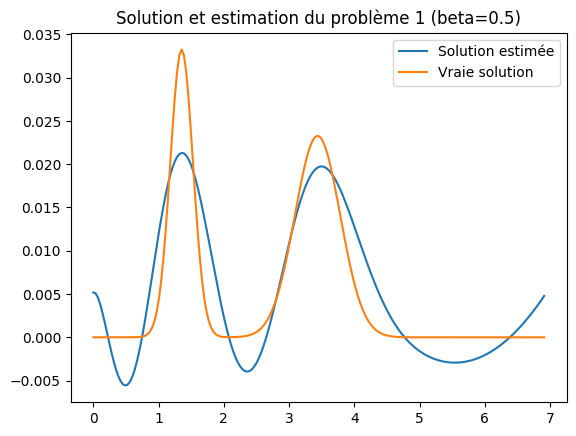

In [ ]:
plt.plot(np.log(T), x_sol )
plt.plot(np.log(T), data)
plt.legend(["Solution estimée", "Vraie solution"])
plt.title("Solution et estimation du problème 1 (beta={})".format(beta))
plt.show()

4. We compute the quadratic error 

$$ E(\hat{x},\bar{x}) = \frac{||\hat{x} - \bar{x} ||^2}{||\bar{x}||^2} $$

In [ ]:
def quadratic_error(x_estim,x_true):
    return np.linalg.norm(x_estim-x_true)**2/np.linalg.norm(x_true)**2 

In [ ]:
print("Quadratic error (beta={}):".format(beta), quadratic_error(x_sol, data))

Quadratic error (beta=0.5): 0.1736648558689933


5. We search for $\beta$ that minimizes the quadratic error

Best beta 0.42857142857142855 quadratic error 0.1717713138547526


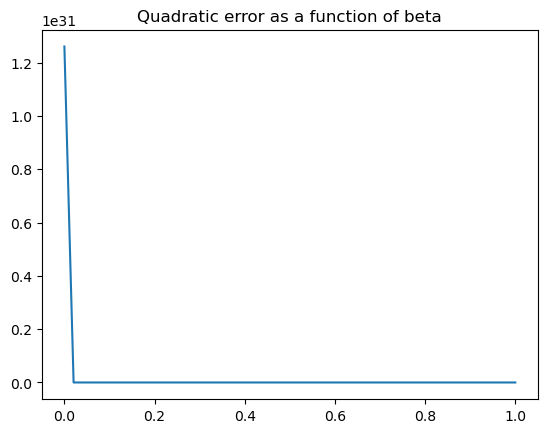

In [ ]:
# Large search
errors =[]
beta_test=np.linspace(0,1,50)
for beta in beta_test:
    x_sol = np.linalg.inv(K.T@K + beta * D.T @ D) @ K.T @ y
    errors.append(quadratic_error(x_sol, data))
plt.plot(beta_test, errors)
plt.title("Quadratic error as a function of beta")

best_beta = beta_test[np.argmin(np.array(errors))]
print("Best beta", best_beta, "quadratic error", min(errors))

In [ ]:
x_sol = np.linalg.inv(K.T@K + best_beta * D.T @ D) @ K.T @ y

Best quadratic error (beta=0.42857): 0.1717713138547526


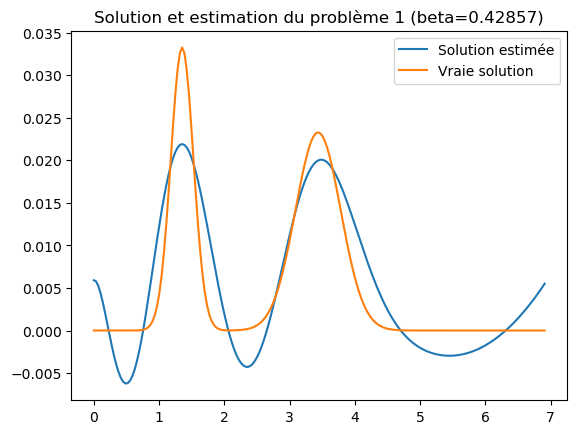

In [ ]:
print("Best quadratic error (beta={}):".format(round(best_beta, 5)), quadratic_error(x_sol, data))
plt.plot(np.log(T), x_sol )
plt.plot(np.log(T), data)
plt.legend(["Solution estimée", "Vraie solution"])
plt.title("Solution et estimation du problème 1 (beta={})".format(round(best_beta, 5)))
plt.show()

### Cas 2 : smoothness prior + constraints

$$\hat{x} = \underset{x \in \mathbb{R}^N}{\text{argmin }} \frac{1}{2}||Kx - y ||^2 + \beta \left(\frac{1}{2} ||Dx||^2 + \iota_{[x_{min},x_{max}]^N}(x)\right) $$ 

1. *Discuss the existence and uniqueness of a solution to Problem (4)*

We can rewrite our probleme as a minimization problem on a compact of $\mathbb{R}^N$. 

We get the following equivalent problem:

$$ \hat{x} = \underset{x \in \mathbf{C}}{\text{argmin }} \frac{1}{2}||Kx - y ||^2 + \beta \frac{1}{2} ||Dx||^2 $$
$$ \text{with } \mathbf{C}=[x_{min},x_{max}]^N$$

that we can rewrite, using the definition of $F$ set in the previous question:

$$ \hat{x} = \underset{x \in \mathbf{C}}{\text{argmin }}F(x) $$
$$ \text{with } \mathbf{C}=[x_{min},x_{max}]^N$$

We have $F \in \Gamma_O$ and $\mathbf{C}$ compact so there exist solutions to the problem.
Plus we have a strong convexity $\equiv$ $\nabla ^2 > 0$ (see Question 1) so we also have the uniqueness of the solution.


2. *Propose an approach to solve problem (4)*
We've seen $F \in \Gamma_O$ differentiable.
We can use the projected gradient theorem.


$$ ||\nabla F(x) = K^T(Kx - y) + \beta\times D^TDx ||_2 \leq |||\nabla F(x) = K^T(Kx - y) + \beta\times D^TDx ||| \times ||x||_2$$

We can take $|||A||| = \max_{\lambda \in \mathbb{Sp}A} |\lambda|$.

Then $F$ has a $\nu$-Lipschitzian gradient wiht $\nu = |||\nabla F(x) = K^T(Kx - y) + \beta\times D^TDx |||$.

And $\nu >0$ as $ \nabla F(x) = K^T(Kx - y) + \beta\times D^TDx \neq 0$.

We can then use the Projected gradient algorithm.


In [ ]:
class ProjectedGradientAlgorithm():
     
        def __init__(self, gamma, lambd, grad, proj, init_x):
            self.gamma = gamma
            self.lambd = lambd
            self.grad = grad
            self.proj = proj
            self.x = init_x
        
        
        def step(self):
            temp = self.x - self.gamma * self.grad(self.x)
            self.x = self.x + self.lambd * (self.proj(temp) - self.x)

In [ ]:
x_min, x_max = min(data), max(data)

def projection(x,x_min,x_max):
    return np.clip(x,x_min,x_max)

def grad(x,beta):
    return (K.T @ K + beta * D.T @ D) @ x - K.T @ y

In [ ]:
mu = np.max(abs((np.linalg.eig((K.T@K + 0.1 * D.T @ D))[0])))
eps = 1e-5
gamma = 2.0/mu - eps
lambd = 1.0

In [ ]:
beta = 0.01

optimisationAlgo = ProjectedGradientAlgorithm(gamma,lambd, lambda x: grad(x,beta),lambda x : projection(x,x_min,x_max), np.ones(len(data)))

for k in trange(100000):
    optimisationAlgo.step()

100%|██████████| 100000/100000 [03:58<00:00, 418.93it/s]


Quadratic error (beta=0.01): 0.08885865200784059


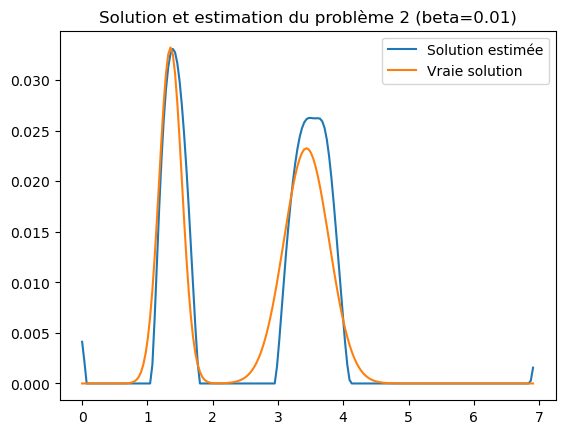

In [ ]:
plt.plot(np.log(T), optimisationAlgo.x )
plt.plot(np.log(T), data)
plt.legend(["Solution estimée", "Vraie solution"])
plt.title("Solution et estimation du problème 2 (beta={})".format(round(beta, 5)))

x_sol = optimisationAlgo.x
print("Quadratic error (beta={}):".format(beta), quadratic_error(x_sol, data))

100%|██████████| 100000/100000 [02:06<00:00, 789.21it/s]


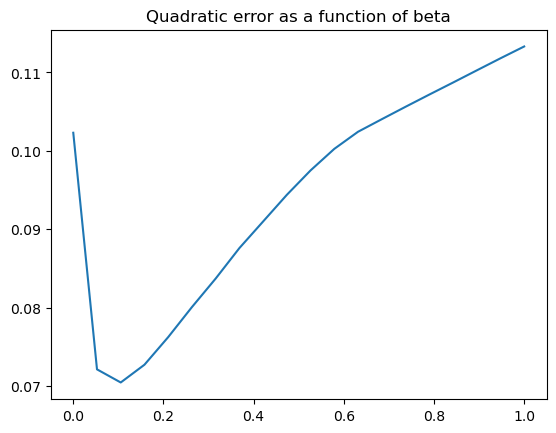

Best beta 0.10526315789473684 quadratic error 0.07046393696877137


In [ ]:
errors =[]
best_beta = np.linspace(0.1,1,10)
x_sols = []
for beta in beta_test:
    mu = np.max(abs((np.linalg.eig((K.T@K + beta * D.T @ D))[0])))
    eps = 1e-5
    gamma = 2.0/mu - eps
    optimisationAlgo = ProjectedGradientAlgorithm(gamma,lambd, lambda x: grad(x,beta),lambda x : projection(x,x_min,x_max), np.ones(len(data)))
    for k in trange(100000):
        optimisationAlgo.step()
    x_sol = optimisationAlgo.x
    x_sols.append(x_sol)
    errors.append(quadratic_error(x_sol, data))

plt.plot(beta_test, errors)
plt.title("Quadratic error as a function of beta")
plt.show()

best_beta = beta_test[np.argmin(np.array(errors))]
best_x_sol = x_sols[np.argmin(errors)]
print("Best beta", best_beta, "quadratic error", min(errors))

Best quadratic error (beta=0.10526): 0.07046393696877137


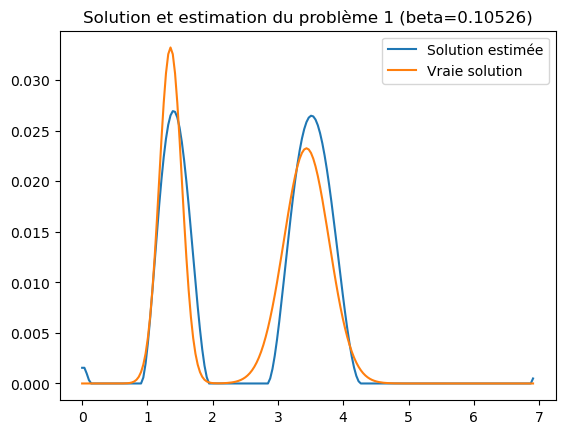

In [ ]:
print("Best quadratic error (beta={}):".format(round(best_beta, 5)), quadratic_error(best_x_sol, data))
plt.plot(np.log(T), best_x_sol )
plt.plot(np.log(T), data)
plt.legend(["Solution estimée", "Vraie solution"])
plt.title("Solution et estimation du problème 1 (beta={})".format(round(best_beta, 5)))
plt.show()

### Cas 3 = sparsity prior

$$\hat{x} = \underset{x \in \mathbb{R}^N}{\text{argmin }} \frac{1}{2}||Kx - y ||^2 + \beta ||x||_1 $$ 

1. *Discuss the existence and uniqueness of a solution to Problem (4)*

Let $F(x)  =  \frac{1}{2}||Kx - y ||^2 + \beta ||x||_1 $. 

- $F$ convex as addition of 2 convexes functions. We thus have $F \in \Gamma_O(\mathbb{R}^N)$.

- We have $||x||_1 \geq ||x||_2$ (equivalency of norms in $\mathbb{R}^N)$.

So, $F(x)  \geq \beta ||x||_2$ and we get $F$ coercive.

So we know there exists at least one solution to the minimization problem.

Do we have $F$ stricly convex ? 


We can check easily that $K^T K$ is not invertible so $f: x \mapsto \frac{1}{2}||Kx - y ||^2 $ is not stricly convex. $x \mapsto ||x||_1$ is not stricly convex neither.

If $dim(Ker(K^TK)) \geq 1$, we don't have strict convexity. 
Indeed, if we take $e_1$  such that $e_1 \in Ker(K^TK)$, we then have 
$$  f(t e_1 + (1-t) 2e_1 )  =  -  [t+ 2 \times (1-t)] y^T K x + ||y|| $$
and 
$$ t f( e_1) = - t y^T K x + t ||y|| $$
$$ (1-t) f( 2 e_1) = - 2(1-t) y^T K x + (1-t) ||y|| $$

so,

$$ t f( e_1) + (1-t) f( 2 e_1) =- t y^T K x + t ||y|| - 2(1-t) y^T K x + (1-t) ||y|| =  -  [t+ 2 \times (1-t)] y^T K x + ||y|| =  f(t e_1 + (1-t) 2e_1 )  $$

so $F$ is not stricly convex, and there is no unicity of solutions to the problem.



2. *Propose an approach to solve problem (4)*

We can use the Forward-Backward algorithm.

- We have $f: x \mapsto \frac{1}{2}||Kx - y ||^2 \in \Gamma_0(\mathbb{R}^N)$.
- $f$ is differentiable and $\nabla f = K^T K$ is $\mu$-Lipschitzian with $\mu = \max_{\lambda \in \mathbb{Sp}K^TK}|\lambda|$.


We need to compute $prox_{\gamma \beta g}$ where $g(x) = ||x||_1$.

We have $g(x) = \sum_i |x_i| = \sum g_i(x_i)$.

So we can compute $\forall i, prox_{g_i}$ separately.

We need to compute, for $\alpha \geq 0$, $prox_{\alpha |\cdot|}(x) = \text{argmin}_y \alpha |y| + \frac{1}{2} |y-x|^2$.

By reasonning on $y=0,y>0,y<0$, we find:

$$ prox_{\alpha |\cdot|}(x) = \left\{
    \begin{array}{ll}
        x-\alpha & \mbox{si } x \geq \alpha \\
        x+\alpha & \mbox{si } x \leq - \alpha \\
        0 & \mbox{sinon.}
    \end{array} 
\right.$$
    
Finally, we have $$ prox_{\gamma \beta g} (x) = \left(x_i \mapsto \left\{
    \begin{array}{ll}
        x_i-\beta\gamma & \mbox{si } x \geq \beta\gamma \\
        x_i+\beta\gamma & \mbox{si } x \leq - \beta\gamma \\
        0 & \mbox{sinon}
    \end{array} \right. 
\right)_i $$



In [ ]:
class ForwardBackwardAlgorithm():
     
        def __init__(self, gamma, lambd, grad, prox, init_x):
            self.gamma = gamma
            self.lambd = lambd
            self.grad = grad 
            self.prox = prox
            self.x = init_x
            self.n = 0
        
        def step(self):
            self.n += 1
            temp = self.x - self.gamma * self.grad(self.x)
            self.x = self.x + self.lambd * (self.prox(temp, self.gamma) - self.x)

In [ ]:
mu = np.max(abs((np.linalg.eig((K.T@K ))[0])))
eps = 1e-5
gamma = 2.0/mu - eps
lambd = 1.0

def prox_l1(x , gamma, beta):
    return np.sign(x) * (np.abs(x) - gamma*beta).clip(0)

def grad3(x):
    return K.T@K@x - K.T@y

In [ ]:
beta = 0.01

optimisationAlgo = ForwardBackwardAlgorithm(gamma,lambd, grad3, lambda x,y : prox_l1(x,y,beta), np.ones(len(data)))

for k in trange(25000):
    optimisationAlgo.step()

100%|██████████| 25000/25000 [00:05<00:00, 4292.23it/s]


Quadratic error (beta=0.01): 0.05688436040272006


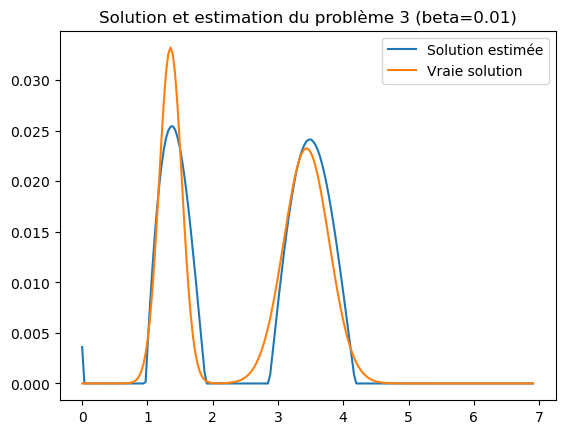

In [ ]:
plt.plot(np.log(T), optimisationAlgo.x )
plt.plot(np.log(T), data)
plt.legend(["Solution estimée", "Vraie solution"])
plt.title("Solution et estimation du problème 3 (beta={})".format(round(beta, 5)))

x_sol = optimisationAlgo.x
print("Quadratic error (beta={}):".format(beta), quadratic_error(x_sol, data))

100%|██████████| 25000/25000 [00:06<00:00, 3623.55it/s]


Best beta 0.1 quadratic error 0.10813639346115822


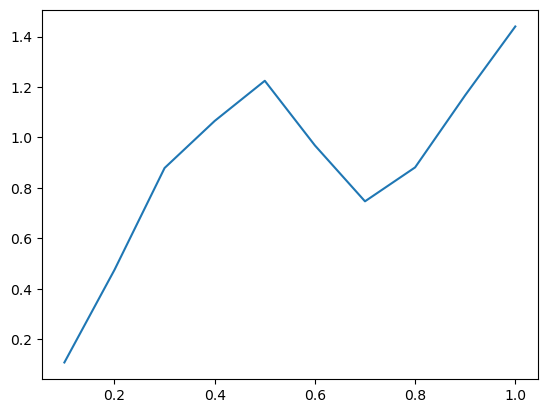

In [ ]:
errors =[]
beta_test = np.linspace(0.1,1,10)
x_sols = []
for beta in beta_test:
    optimisationAlgo = ForwardBackwardAlgorithm(gamma,lambd, grad3, lambda x,y : prox_l1(x,y,beta), np.ones(len(data)))
    for k in trange(25000):
        optimisationAlgo.step()
    x_sol = optimisationAlgo.x
    x_sols.append(x_sol)
    errors.append(quadratic_error(x_sol, data))
plt.plot(beta_test, errors)

best_beta = beta_test[np.argmin(np.array(errors))]
best_x_sol = x_sols[np.argmin(errors)]
print("Best beta", best_beta, "quadratic error", min(errors))

Best quadratic error (beta=0.1): 0.10813639346115822


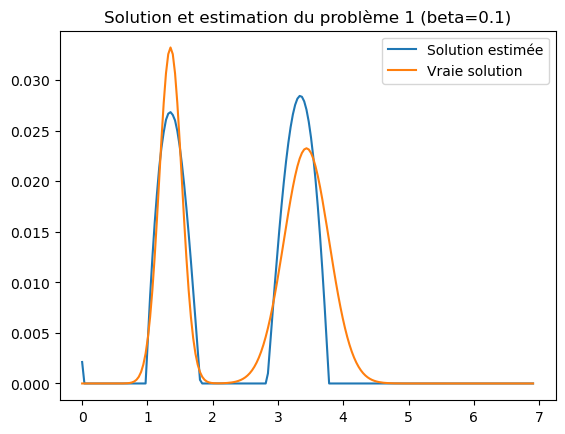

In [ ]:
print("Best quadratic error (beta={}):".format(round(best_beta, 5)), quadratic_error(best_x_sol, data))
plt.plot(np.log(T), best_x_sol)
plt.plot(np.log(T), data)
plt.legend(["Solution estimée", "Vraie solution"])
plt.title("Solution et estimation du problème 1 (beta={})".format(round(best_beta, 5)))
plt.show()

# Reconstruction of DOSY NMR signals - Part II

1.  __a) ent convex__
- If $x<0$ or $y<0$ we have $\varphi(tx+(1-t)y) = +\infty = t\varphi(x) + (1-t) \varphi(y)$.
- If $x,y\geq0$ and $x=0$: $\varphi((1-t)y) = (1-t)y \log((1-t)y) \leq (1-t)y \log((1-t)y) $ as $\log$ increasing function.
- If $x,y>0$. We have $(x\log x)'' = \frac{1}{x} \geq 0$.

So $\varphi$ convex.
And then $ent$ is also convex as it is a sum of convex functions. 


__b) ent proper__

$ent((1,1,...,1)) = (0,0,...,0)< + \infty$ so $\text{dom } ent \neq \emptyset$ 

__c) ent lsc__

$\varphi$ is continuous on $[0,+\infty]$ as $x \log x \to_{x\to0^+} 0$.

$\varphi$ is constant and continuous on $[-\infty,0[$.

$\varphi$ is lsc on $[-\infty,+\infty]$ because if $x_n\to0^-$ then $\varphi(x_n)=+\infty > \varphi(0)=0$.

Then, summing lsc functions implies $ent$ lsc. 

__d) ent differentiable__

$\varphi$ not differentiable in $0$ (not continous) so $ent$ not differentiable (in $(0,\dots,0)$ for example).



2. We minimize the sum of 2 functions in $\Gamma_0$.

We have $ent$ coercive, because if $x_n \to +\infty$, we have at least one coordinate $x^i$ such a:

$x^i_n \to + \infty$ and $\varphi(x^i_n) \to + \infty$
or $x^i_n \to - \infty$ and $\varphi(x^i_n) \to + \infty$.

so, as $\frac{1}{2}||Kx-y||^2 \geq 0$, we have that the sum of the two functions is also coercive.

We minimize this sum on $\mathbb R^N$ wich is a closed convex set.
 
So we have the existence of:
$$\hat x = inf_x \frac{1}{2}||Kx-y||^2 + ent(x)$$

- Is $ent$ strictly convex ? Yes, because $\varphi$ is stritcly convex, and $ent$ is defined as the sum of stricly convex functions. 

So we have also the uniqueness of the solution.


In [ ]:
from math import *

In [ ]:
def lambert_o_exp(z):
    if z > 100 :
        return z - log(z)        
    if z < -20 :
        return 0
    w = 1
    v = float("inf")
    x = exp(z)
    while abs(w-v)/abs(w)>1e-8:
        v = w
        e = exp(w)
        f = w*e - x 
        w = w - f/((e*(w+1) - (w+2)*f/(2*w+2)))
    return w

lambert_vec = np.vectorize(lambert_o_exp)

In [ ]:
def prox_ent(x, gamma, beta):
    return gamma*beta * lambert_vec((x/(gamma*beta)) - 1 - np.log(gamma*beta))

In [ ]:
beta = 0.002
mu = np.max(abs((np.linalg.eig((K.T@K ))[0])))
eps = 1e-5
gamma = 2.0/mu - eps
lambd = 1.0

optimisationAlgo = ForwardBackwardAlgorithm(gamma,lambd, grad3, lambda x,y : prox_ent(x,y,beta), np.ones(len(data)))
for k in trange(10000):
    optimisationAlgo.step()

100%|██████████| 10000/10000 [00:14<00:00, 697.75it/s]


Quadratic error (beta=0.002): 0.3236379466459278


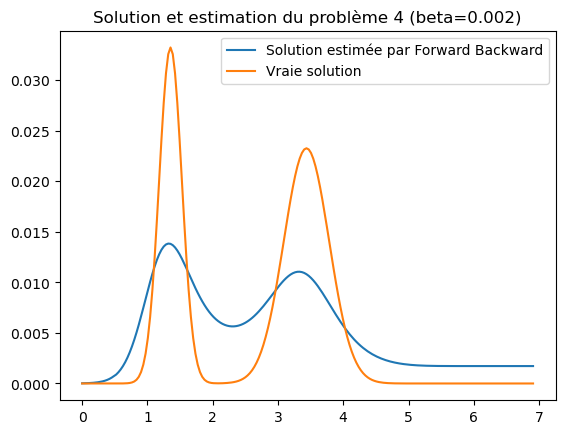

In [ ]:
x_sol = optimisationAlgo.x 
plt.plot(np.log(T), x_sol)
plt.plot(np.log(T), data)
plt.legend(["Solution estimée par Forward Backward", "Vraie solution"])
plt.title("Solution et estimation du problème 4 (beta={})".format(round(beta, 5)))
print("Quadratic error (beta={}):".format(beta), quadratic_error(x_sol, data))
plt.show()

100%|██████████| 10000/10000 [00:11<00:00, 860.84it/s]


Best beta 0.0001 quadratic error 0.08044686263039674


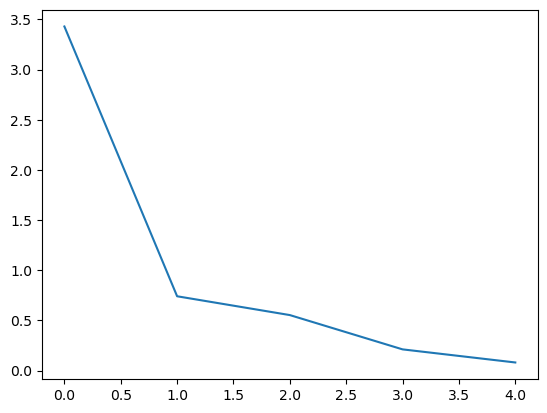

In [ ]:
errors =[]
beta_test=[10**-k for k in range(5)]
x_sols = []
for beta in beta_test:
    optimisationAlgo = ForwardBackwardAlgorithm(gamma,lambd, grad3, lambda x,y : prox_ent(x,y,beta), np.ones(len(data)))
    for k in trange(10000):
        optimisationAlgo.step()
    x_sol = optimisationAlgo.x
    x_sols.append(x_sol)
    errors.append(quadratic_error(x_sol, data))
plt.plot(range(len(beta_test)), errors)

best_beta = beta_test[np.argmin(np.array(errors))]
best_x_sol = x_sols[np.argmin(errors)]
print("Best beta", best_beta, "quadratic error", min(errors))

Best quadratic error (beta=0.0001): 0.08044686263039674


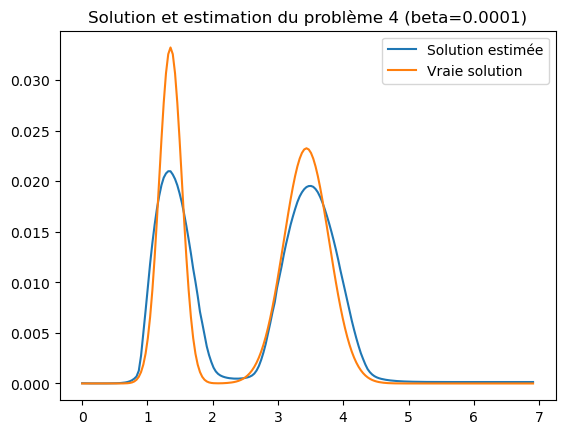

In [ ]:
print("Best quadratic error (beta={}):".format(round(best_beta, 5)), quadratic_error(best_x_sol, data))
plt.plot(np.log(T), best_x_sol )
plt.plot(np.log(T), data)
plt.legend(["Solution estimée", "Vraie solution"])
plt.title("Solution et estimation du problème 4 (beta={})".format(round(best_beta, 5)))
plt.show()

### Douglas-Rachford

In [ ]:
class DouglasRachfordAlgorithm():
     
        def __init__(self, gamma, lambd, prox_f, prox_g, init_x):
            self.gamma = gamma
            self.lambd = lambd
            self.prox_f = prox_f 
            self.prox_g = prox_g
            self.x = init_x
            self.n = 0
            self.errors= []
        
        def step(self):
            self.n += 1
            self.y = self.prox_g(self.x, self.gamma)
            z = self.prox_f(2*self.y - self.x, self.gamma)
            self.x =  self.x + self.lambd * (z-self.y)
            self.errors.append(quadratic_error(self.y, data))

In [ ]:
def prox_f_norm(x, gamma):
    return np.linalg.inv(gamma * K.T@K + np.eye(N)) @ (x + gamma * K.T @ y)

In [ ]:
beta = 10**(-2)
gamma = 1.99/mu
lambd = 1.999

optimisationAlgo = DouglasRachfordAlgorithm(gamma,lambd, prox_f_norm, lambda x,y : prox_ent(x,y,beta), np.ones(len(data)))
for k in range(1000):
    optimisationAlgo.step()

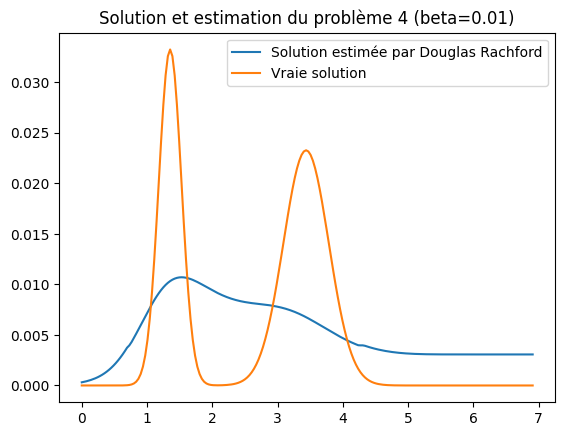

In [ ]:
plt.plot(np.log(T), optimisationAlgo.y )
plt.plot(np.log(T), data)
plt.legend(["Solution estimée par Douglas Rachford", "Vraie solution"])
plt.title("Solution et estimation du problème 4 (beta={})".format(round(beta, 5)))
plt.show()

0.8231149696149187


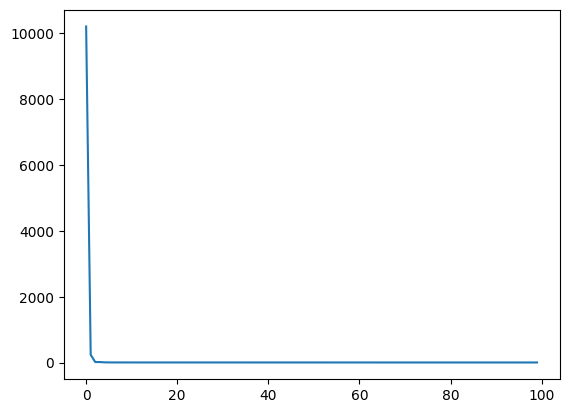

In [ ]:
plt.plot(range(100), optimisationAlgo.errors)##[1750:max_steps])
print(quadratic_error( optimisationAlgo.y, data))


Best beta 0.0001 quadratic error 0.056857139765003666


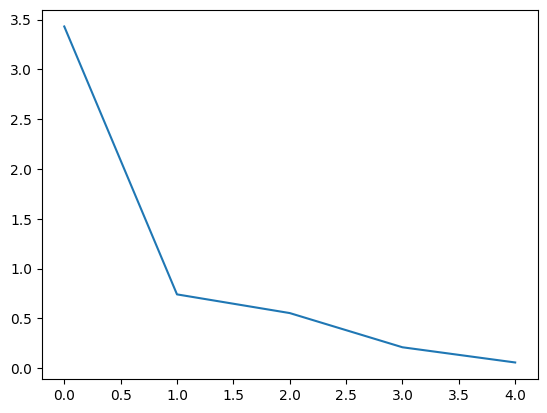

In [ ]:
errors =[]
beta_test=[10**-k for k in range(5)]
x_sols = []
for beta in beta_test:
    optimisationAlgo = DouglasRachfordAlgorithm(gamma,lambd, prox_f_norm, lambda x,y : prox_ent(x,y,beta), np.ones(len(data)))
    for k in range(20000):
        
        optimisationAlgo.step()
    x_sol = optimisationAlgo.y
    x_sols.append(x_sol)
    errors.append(quadratic_error(x_sol, data))
plt.plot(range(len(beta_test)), errors)

best_beta = beta_test[np.argmin(np.array(errors))]
best_x_sol = x_sols[np.argmin(errors)]
print("Best beta", best_beta, "quadratic error", min(errors))

Best quadratic error (beta=0.0001): 0.056857139765003666


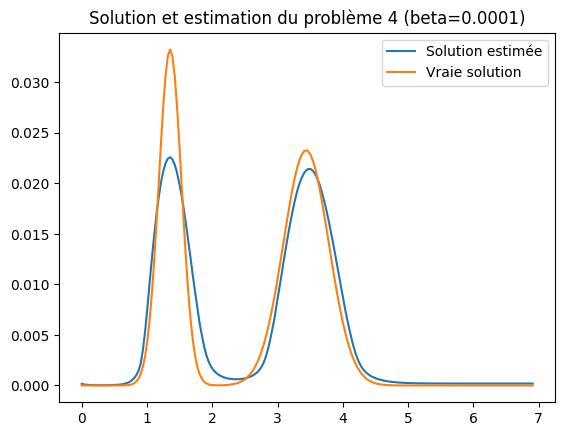

In [ ]:
print("Best quadratic error (beta={}):".format(round(best_beta, 5)), quadratic_error(best_x_sol, data))
plt.plot(np.log(T), best_x_sol )
plt.plot(np.log(T), data)
plt.legend(["Solution estimée", "Vraie solution"])
plt.title("Solution et estimation du problème 4 (beta={})".format(round(best_beta, 5)))
plt.show()

## Question 7: comparison of the different regularizations.

### Calculation time + quadratic error

In [ ]:
from time import time

#### Smoothness prior

In [ ]:
t1 = time()
beta=0.5
x_sol_smoothness = np.linalg.inv(K.T@K + beta * D.T @ D) @ K.T @ y
t_smoothness = time() - t1
quad_smoothness = quadratic_error(x_sol_smoothness, data)

#### Smoothness prior + constraints

In [ ]:
t1 = time()
mu = np.max(abs((np.linalg.eig((K.T@K + 0.1 * D.T @ D))[0])))
eps = 1e-5
gamma = 2.0/mu - eps
lambd = 1.0
beta = 0.10526
optimisationAlgo = ProjectedGradientAlgorithm(gamma,lambd, lambda x: grad(x,beta),lambda x : projection(x,x_min,x_max), np.ones(len(data)))
for k in trange(100000):
    optimisationAlgo.step()
t_smoothness_cons = time() - t1
x_sol_cons = optimisationAlgo.x
quad_smoothness_cons = quadratic_error(x_sol_cons, data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:23<00:00, 1200.46it/s]


#### Sparsity prior 

In [ ]:
t1 = time()
mu = np.max(abs((np.linalg.eig((K.T@K + 0.1 * D.T @ D))[0])))
eps = 1e-5
gamma = 2.0/mu - eps
lambd = 1.0
beta = 0.01
optimisationAlgo = ForwardBackwardAlgorithm(gamma,lambd, grad3, lambda x,y : prox_l1(x,y,beta), np.ones(len(data)))
for k in trange(25000):
    optimisationAlgo.step()
t_spars = time() - t1
x_sol_spars = optimisationAlgo.x
quad_spars = quadratic_error(x_sol_spars, data)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:06<00:00, 3842.85it/s]


#### Maximum entropy regularization (Forward-Backward)

In [ ]:
t1 = time()
mu = np.max(abs((np.linalg.eig((K.T@K + 0.1 * D.T @ D))[0])))
eps = 1e-5
gamma = 2.0/mu - eps
lambd = 1.0
beta = 0.0001
optimisationAlgo = ForwardBackwardAlgorithm(gamma,lambd, grad3, lambda x,y : prox_ent(x,y,beta), np.ones(len(data)))
for k in trange(25000):
    optimisationAlgo.step()
t_ent = time() - t1
x_sol_ent = optimisationAlgo.x
quad_ent = quadratic_error(x_sol_ent, data)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:18<00:00, 1373.18it/s]


#### Maximum entropy regularization (Douglas-Rachford)

In [ ]:
t1 = time()
mu = np.max(abs((np.linalg.eig((K.T@K + 0.1 * D.T @ D))[0])))
eps = 1e-5
gamma = 2.0/mu - eps
lambd = 1.0
beta = 0.0001
optimisationAlgo = DouglasRachfordAlgorithm(gamma,lambd, prox_f_norm, lambda x,y : prox_ent(x,y,beta), np.ones(len(data)))
for k in trange(25000):
    optimisationAlgo.step()
t_ent_dr = time() - t1
x_sol_ent_dr = optimisationAlgo.y
quad_ent_dr = quadratic_error(x_sol_ent_dr, data)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:56<00:00, 441.83it/s]


### Comparison

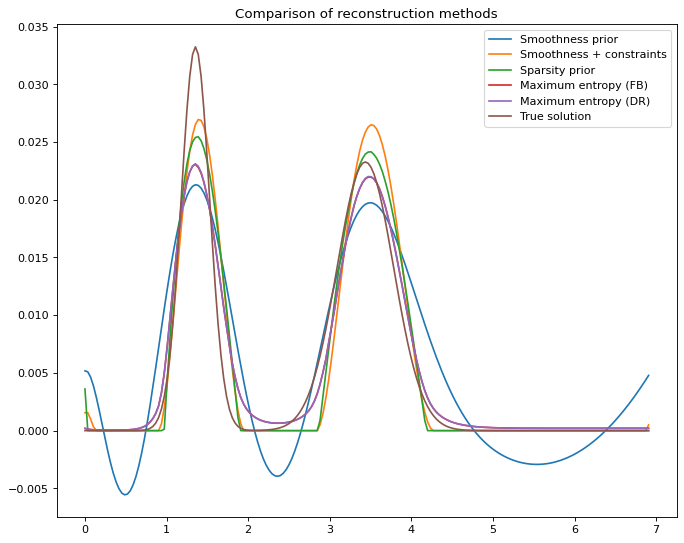

In [ ]:
plt.figure(figsize=(10, 8), dpi=80)
plt.plot(np.log(T), x_sol_smoothness )
plt.plot(np.log(T), x_sol_cons )
plt.plot(np.log(T), x_sol_spars )
plt.plot(np.log(T), x_sol_ent)
plt.plot(np.log(T), x_sol_ent_dr)
plt.plot(np.log(T), data)

plt.legend(["Smoothness prior", "Smoothness + constraints", "Sparsity prior","Maximum entropy (FB)", "Maximum entropy (DR)", "True solution"])
plt.title("Comparison of reconstruction methods")
plt.show()

Text(0.5, 1.0, 'Comparison of calculation time')

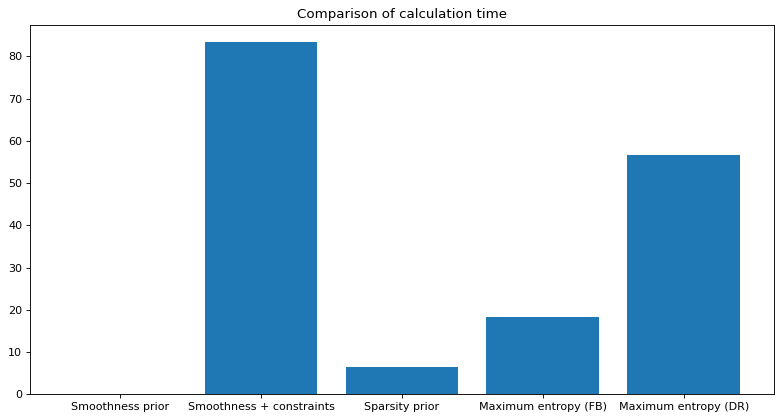

In [ ]:
plt.figure(figsize=(12, 6), dpi=80)
plt.bar(["Smoothness prior", "Smoothness + constraints", "Sparsity prior","Maximum entropy (FB)", "Maximum entropy (DR)"],[t_smoothness,t_smoothness_cons,t_spars,t_ent,t_ent_dr])
plt.title("Comparison of calculation time")

<BarContainer object of 5 artists>

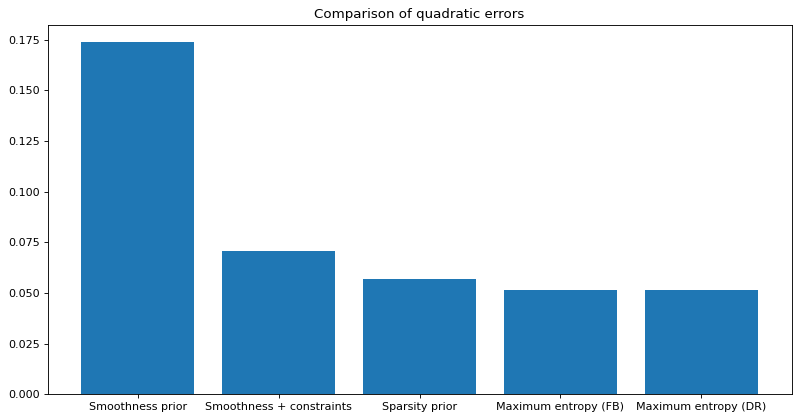

In [ ]:
plt.figure(figsize=(12, 6), dpi=80)
plt.title("Comparison of quadratic errors")
plt.bar(["Smoothness prior", "Smoothness + constraints", "Sparsity prior","Maximum entropy (FB)","Maximum entropy (DR)"],[quad_smoothness,quad_smoothness_cons,quad_spars,quad_ent, quad_ent_dr])

**Conclusion**

When comparing the quadratic error (on an optimized $\beta$) the best formulation of the problem is the one using entropy as a regularizer. The quadratic error at the converging state is the lowest among the other formulations, whatever algorithm used.


However, when we take into account the computation time, Douglas-Rachford algorithm is much slower than the Forward-Backward algorithm.


To solve this biology problem in practice, one must choose either 
*  the formulation using the entropy as regularizer solved by the Forward-Backward algorithm, to have the best performances.
*  the sparsity prior formulation (solved by the Forward-Backward algorithm), to have a relatively good result in a short computation time.

## Question 8

We can rewrite the condition as a minimization problem on a convex.
Indeed, we have:

$$||Kx-y||^2 \leq \eta M \sigma^2 \iff Kx \in \mathcal{B} \left(y,\sqrt{\eta M \sigma^2 }\right)$$.

Where $\mathcal{B}(a,r)$ refers to a ball centered on $a$ of radius $r$.

So, let's rewrite the minimization under constraints problem as:

$$ \min_x ent(x) + \iota_C \circ K (x)$$ 

with $C = \mathcal{B} \left(y,\sqrt{\eta M \sigma^2 }\right)$. 

We can see it as:
$$\min_x g_1 \circ L_1 (x) + g_2 \circ L_2 (x)$$

where $g_1 = ent, L_1 = Id, g_2 = \iota_C, L_2 = K$.

We have $g_1 \in \Gamma_0  (\mathbb{R}^N)$ et $g_2 \in  \Gamma_0 (\mathbb{R}^M)$

To use $PPXA+$ algorithm, we should have $Id + K^T K$ invertible ($Id$ invertible and $K^T K$ semi positive implies it). 


We also need explicit proximal operators for $g_1$ and $g_2$. 
We have all ready computed $prox_{\gamma ent}$.
We need to compute $prox_{\gamma \iota_c}$: it's the projection on $C$.




In [ ]:
N = len(data)
invert_matrix = np.linalg.inv(np.eye(N) + K.T@K)

class PPXA():
     
        def __init__(self, gamma, lambd, prox_g_1, prox_g_2, init_x_1,init_x_2):
            self.gamma = gamma
            self.lambd = lambd
            self.prox_g_1 = prox_g_1
            self.prox_g_2 = prox_g_2
            self.x_1 = init_x_1
            self.x_2 = init_x_2
            self.v = invert_matrix @  (self.x_1 + K.T @ self.x_2)
            self.n = 0
            self.errors = []
            
        def step(self):
            self.n += 1
            self.y_1 = self.prox_g_1(self.x_1, self.gamma)
            self.y_2 = self.prox_g_2(self.x_2, self.gamma)
            c = invert_matrix @  (self.y_1 + K.T @ self.y_2)
            self.x_1 = self.x_1 + self.lambd *(2*c - self.v - self.y_1)
            self.x_2 = self.x_2 + self.lambd *(K@(2*c - self.v) - self.y_2)
            self.v_pred = self.v
            self.v = self.v + self.lambd*(c - self.v)
            self.errors.append(quadratic_error(self.v, data))

In [ ]:
#eta = 0.001
eta = 0.00001
def proj_sphere(x, gamma):
    return np.sqrt(eta * M * sigma**2)  * (x-y)/ np.linalg.norm(x-y)

In [ ]:
#gamma = 0.0001
#lambd = 1.9999999
gamma = 1.99/mu
lambd = 1.999999
max_steps = 25000
optimisationAlgo = PPXA(gamma,lambd,  lambda x,y : prox_ent(x,y,1), proj_sphere,  np.ones(N),np.ones(M))
for k in trange(max_steps):
    optimisationAlgo.step()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:05<00:00, 4472.38it/s]


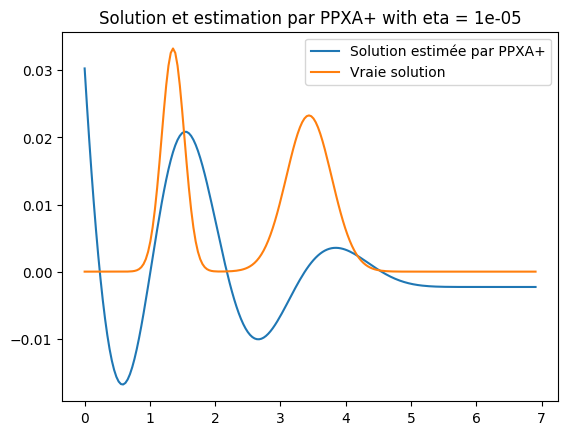

In [ ]:
plt.plot(np.log(T), optimisationAlgo.v)
plt.plot(np.log(T), data)
plt.legend(["Solution estimée par PPXA+", "Vraie solution"])
plt.title("Solution et estimation par PPXA+ with eta = {}".format(eta))
plt.show()


1.1169728419689604
2.4108819277693425
1.1169728419689604


Text(0.5, 1.0, 'Quadratic error during training')

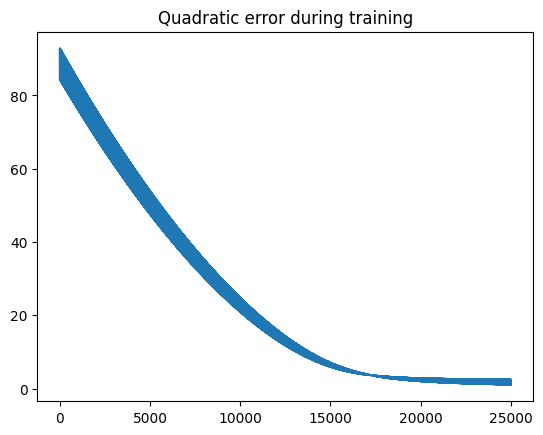

In [ ]:
plt.plot(range(max_steps), optimisationAlgo.errors)##[1750:max_steps])
print(quadratic_error( optimisationAlgo.v, data))
print(quadratic_error( optimisationAlgo.v_pred, data))
print(optimisationAlgo.errors[-1])
plt.title("Quadratic error during training")